In [64]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rcParams
from matplotlib import animation, rc
from IPython.display import HTML
from control.matlab import *
from control import place
from scipy import integrate
# Python control toolbox available at https://python-control.readthedocs.io/

plt.rcParams['figure.figsize'] = [8, 8]
plt.rcParams.update({'font.size': 18})
plt.rcParams['animation.html'] = 'jshtml'

Error: Jupyter cannot be started. Error attempting to locate jupyter: Select an Interpreter to start Jupyter

In [65]:
m = 1
M = 5
L = 2
g = -10
d = 1

b = 1 # pendulum up (b=1)

A = np.array([[0,1,0,0],\
              [0,-d/M,b*m*g/M,0],\
              [0,0,0,1],\
              [0,-b*d/(M*L),-b*(m+M)*g/(M*L),0]])

B = np.array([0,1/M,0,b/(M*L)]).reshape((4,1))

print(np.linalg.eig(A)[0])       # Eigenvalues
print(np.linalg.det(ctrb(A,B)))  # Determinant of controllability matrix

[ 0.         -2.431123   -0.23363938  2.46476238]
0.0196


In [66]:
## Design LQR Controller
Q = np.eye(4)
#Q[0,0] = 5
#Q[2,2] = 5
R = 0.0001

#K = lqr(A,B,Q,R)[0]
p = np.array([-1, -1.1, -1.2,-1.3])
#p = np.array([-4, -4.1, -4.2,-4.3])

K = place(A,B,p)

In [67]:
## ODE RHS Function Definition
def pendcart(x,t,m,M,L,g,d,uf):
    u = uf(x) # evaluate anonymous function at x
    Sx = np.sin(x[2])
    Cx = np.cos(x[2])
    D = m*L*L*(M+m*(1-Cx**2))
    
    dx = np.zeros(4)
    dx[0] = x[1]
    dx[1] = (1/D)*(-(m**2)*(L**2)*g*Cx*Sx + m*(L**2)*(m*L*(x[3]**2)*Sx - d*x[1])) + m*L*L*(1/D)*u
    dx[2] = x[3]
    dx[3] = (1/D)*((m+M)*m*g*L*Sx - m*L*Cx*(m*L*(x[3]**2)*Sx - d*x[1])) - m*L*Cx*(1/D)*u
    
    return dx

In [68]:
## Simulate closed-loop system
tspan = np.arange(0,10,0.001)
x0 = np.array([-1,0,np.pi+0.2,0]) # Initial condition
wr = np.array([1,0,np.pi,0])      # Reference position
u = lambda x: -K@(x-wr)           # Control law

x = integrate.odeint(pendcart,x0,tspan,args=(m,M,L,g,d,u))

input = np.matmul(-K,np.transpose(x-wr))
print(tspan.shape)


(10000,)


C:\Users\Kevin\AppData\Local\Temp\ipykernel_1272\1611201475.py:18: MatplotlibDeprecationWarning: Setting data with a non sequence type is deprecated since 3.7 and will be remove two minor releases later
  p_cart.set_data(x_iter,0.1+H/2)


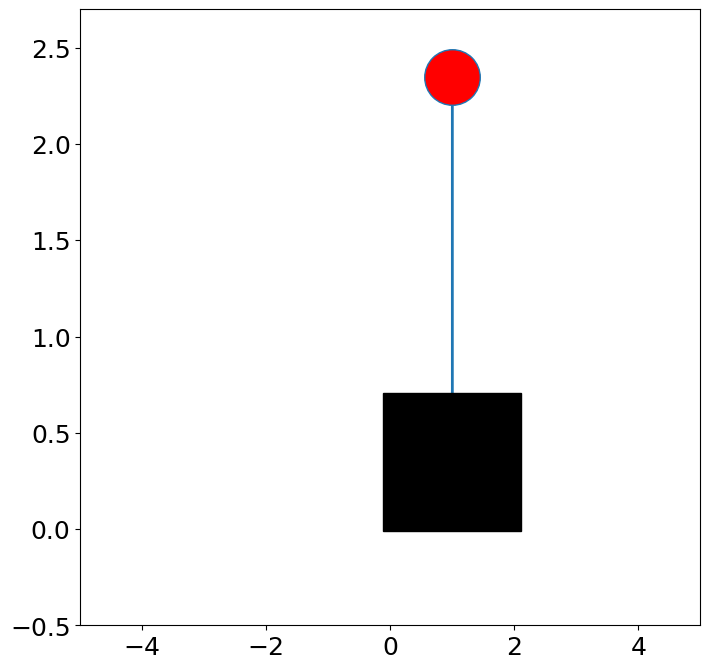

In [69]:
fig,ax = plt.subplots()
H = 0.5*np.sqrt(M/5)
p_pend, = plt.plot([],[],'o-',linewidth=2,ms=40,markerfacecolor='r')
p_cart, = plt.plot([],[],'ks',ms=100)

x_plot = x[::100,:]
t_plot = tspan[::100]

def init():
    ax.set_xlim(-5,5)
    ax.set_ylim(-0.5, 2.7)
    return x

def animate(iter):
    x_iter = x_plot[iter,0]
    th_iter = x_plot[iter,2]
    
    p_cart.set_data(x_iter,0.1+H/2)
    p_pend.set_data(x_iter+np.array([0,L*np.sin(th_iter)]),\
                    0.1+H/2+np.array([0,-L*np.cos(th_iter)]))
    return p_pend

anim = animation.FuncAnimation(fig,animate,init_func=init,frames=len(t_plot),interval=50,blit=False,repeat=False)
HTML(anim.to_jshtml())

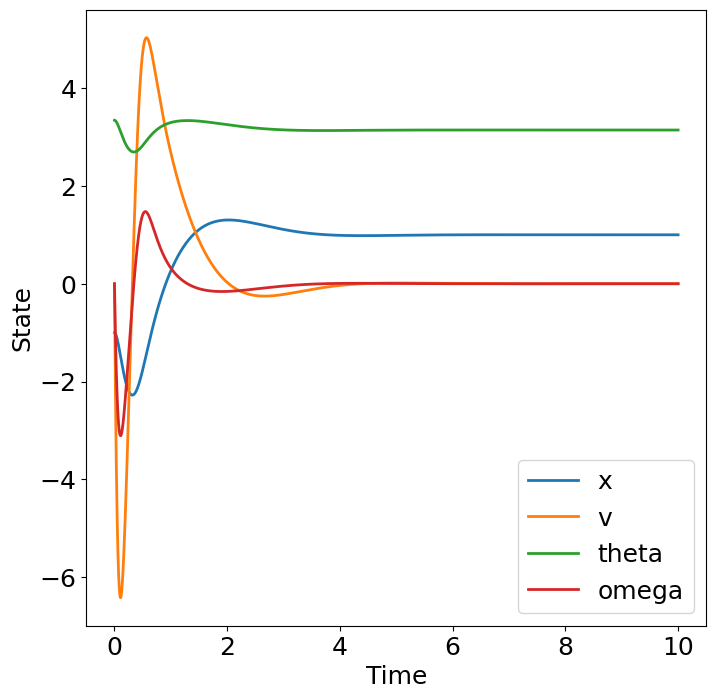

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


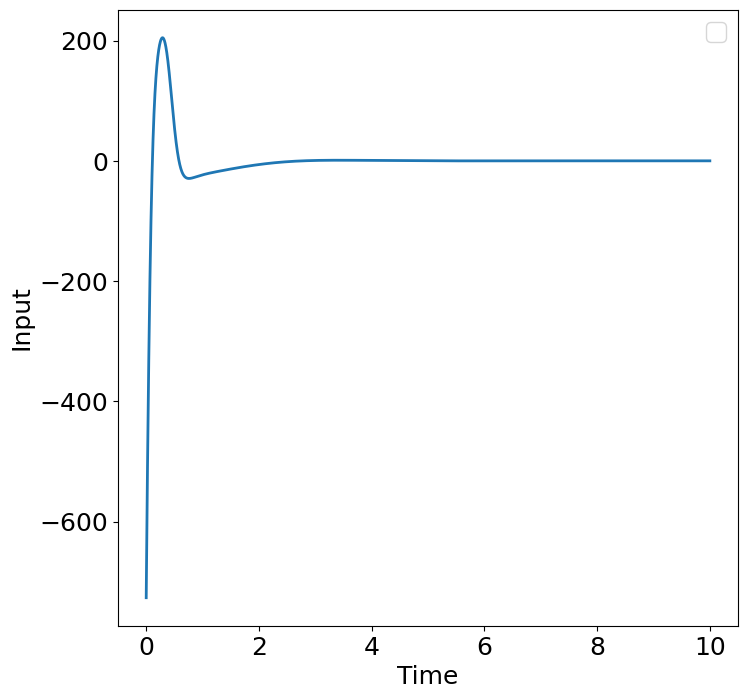

In [70]:
plot_labels = ('x','v','theta','omega')
[plt.plot(tspan,x[:,j],linewidth=2,label=plot_labels[j]) for j in range(4)]
plt.xlabel('Time')
plt.ylabel('State')

plt.legend()
plt.show()

plt.plot(tspan,np.transpose(input[:]),linewidth=2) 
plt.xlabel('Time')
plt.ylabel('Input')

plt.legend()
plt.show()

In [71]:
## Compare with many examples of Pole Placement
JLQR = np.zeros(len(tspan))
for k in range(len(tspan)):
    JLQR[k] = (x[k,:]-wr) @ Q @ (x[k,:]-wr) + (u(x[k,:])**2)*R
    
t_plot = tspan[::50]
all_x_plot = np.zeros((len(t_plot),4,100))
all_J = np.zeros((len(tspan),100))
all_Jz = np.zeros((len(tspan)-1,100))

for count in range(100):
    p = -0.5 - 3*np.random.rand(4)
    K = place(A,B,p)
    u = lambda x: -K@(x-wr)
    
    x = integrate.odeint(pendcart,x0,tspan,args=(m,M,L,g,d,u))
    all_x_plot[:,:,count] = x[::50,:]
    for k in range(len(tspan)):
        all_J[k,count] = (x[k,:]-wr)@Q@(x[k,:]-wr) + (u(x[k,:])**2)*R
    
    all_Jz[:,count] = integrate.cumtrapz(all_J[:,count])
    

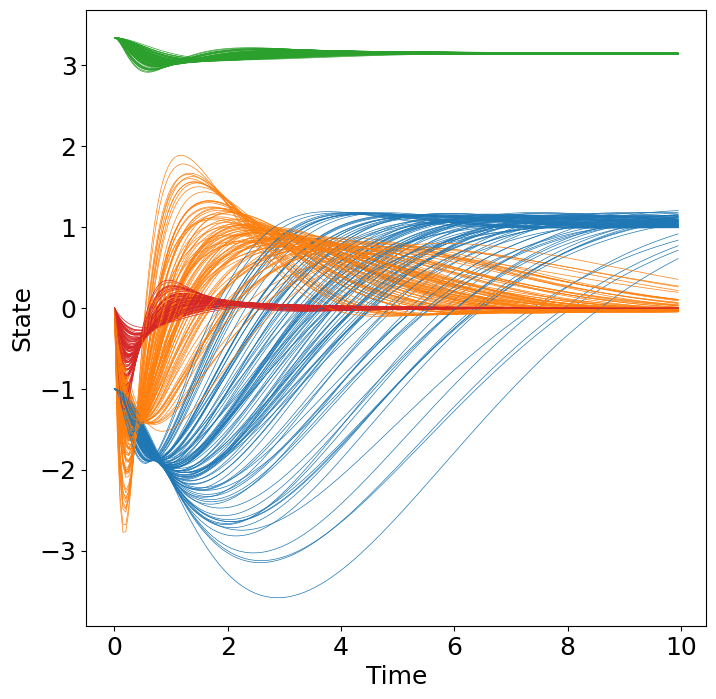

In [72]:
## Plots
for count in range(100):
    plt.plot(t_plot,all_x_plot[:,:,count],linewidth=0.5)
    plt.gca().set_prop_cycle(None) # reset color cycle
    
plt.xlabel('Time')
plt.ylabel('State')
plt.show()

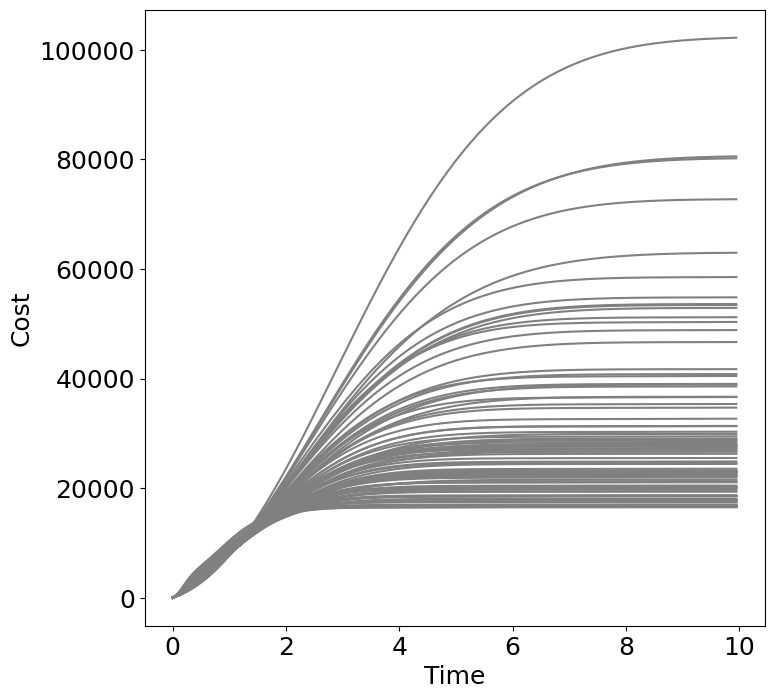

In [73]:
for count in range(100):
    plt.plot(t_plot,all_Jz[::50,count],color=(0.5,0.5,0.5))
    
plt.xlabel('Time')
plt.ylabel('Cost')
plt.show()